# Notebook to make plots of the correlators for the paper

In [1]:
### 📦 Imports and Initialization
# Load standard and plotting packages
# Core Julia Libraries
using Random
using Statistics
using LinearAlgebra
using Dates

# I/O and Data
using DelimitedFiles
using JLD
using DataFrames
using DataStructures

# Plotting and Visualization
using Plots
using Colors
using LaTeXStrings

# Graph Algorithms
using Graphs

# Statistical Modeling
using GLM

# Project-specific Functions
include("common_functions.jl")

# Optional: plotting defaults (uncomment and customize if needed)
# default(framestyle = :box, aspect_ratio = :auto, fontfamily = "Times")

basis_path_to_all_path (generic function with 1 method)

# Defaults

In [2]:

### 🎨 Plotting Style Defaults
# Set up consistent plot style parameters
# Plot size presets
size_sm = 1.2 .* (350, 250)
size_paper = 1.2 .* (350, 180)

# Font sizes
fntsize = 11
legendfntsize = 9

# Set default plotting styles
default(
    legendfontsize = legendfntsize,
    xformatter = :latex,
    yformatter = :latex,
    framestyle = :box,
    xtickfontsize = fntsize,
    ytickfontsize = fntsize,
    xguidefontsize = fntsize,
    yguidefontsize = fntsize,
    size = size_paper
)

# Color definitions (final choices)
col1 = :dodgerblue
col2 = :tomato
col3 = :blue2
col4 = :red

# Alternative color suggestions (uncomment to experiment)
# col2 = :firebrick
# col2 = :brown3
# col2 = :maroon3
# col2 = :red4

:red

# Define plotting functions

In [3]:

### 📊 Correlator Plotting Function
# Define utility function to plot and fit correlators with error ribbons
#--- Utility functions for plotting correlators with error bands and exponential fits ---#

function getlims(corr, log_dev)
    uplim = 10 .^ (log10.(corr) .+ log_dev) .- corr
    dnlim = corr .- 10 .^ (log10.(corr) .- log_dev)
    return (dnlim, uplim)
end

function plt_std(p, xarr, yarr, log_dev, lc=:black, lbl="")
    for i in 1:length(xarr)
        x, y, dev = xarr[i], yarr[i], log_dev[i]
        uplim = 10 ^ (log10(y) + dev)
        dnlim = 10 ^ (log10(y) - dev)
        plot!([x, x], [uplim, dnlim], label="", line=(3.0, lc, :solid, :path))
    end
    plot!([1000, 1000], [1000, 2000], label=lbl)
    return p
end

function clip_negative(vec)
    return [v > 0 ? v : 1e-10 for v in vec]
end

function getrib(corr, sd)
    uplim = corr .+ sd
    dnlim = clip_negative(corr .- sd)
    return (corr .- dnlim, sd)
end

function plt_corr(data2, data3, trimlim, line=true; verbose=true, mkrsz=4)
    dist2, corr2, sdev2, err2 = data2
    dist3, corr3, sdev3, err3 = data3

    # Region R2 plot styles
    mshape2, lbl2 = :rect, L"$R_1$"
    cola2, colb2 = :tomato, :red

    # Region R3 plot styles
    mshape3, lbl3 = :circle, L"$R_2$"
    cola3, colb3 = :dodgerblue, :blue

    # Shaded ribbons
    plot!(dist2, corr2, ribbon=getrib(corr2, sdev2), linewidth=0.0, label=false, fillcolor=cola2, fillstyle=:\)
    plot!(dist3, corr3, ribbon=getrib(corr3, sdev3), linewidth=0.0, label=false, fillcolor=cola3, fillstyle=:/)

    # Region R2 points and spread
    scatter!(dist2, corr2, yerr=err2, label=lbl2, markercolor=colb2, markershape=mshape2,
             markerstrokecolor=colb2, markersize=mkrsz)
    plot!(Shape([(-1,-1), (-2,-1), (-2,-2), (-1,-2)]), fillcolor=plot_color(cola2, 1.0),
          fillstyle=:\, label=L"$R_1~\textrm{Spread}$")

    # Fit for R2
    ξ2 = 0.0
    if line
        ssd, ssc = distance_trim(dist2, log.(corr2), trimlim...)
        data = DataFrame(x=convert(Vector{Float64}, ssd), y=convert(Vector{Float64}, ssc))
        lm2 = lm(@formula(y ~ x), data)
        c, m = coef(lm2)
        m_err = stderror(lm2)[2]
        ξ2, eξ = 1/m, m_err/m^2
        verbose && println("R2: m = $m ± $m_err,  ξ = $ξ2 ± $eξ")
        plot!(dist2, exp.(m .* dist2 .+ c), linecolor=cola2, label=false)
    end

    # Clip negative bars for R2
    for i in findall(i -> corr2[i] - err2[i] < 0, eachindex(err2))
        plot!([dist2[i], dist2[i]], [1e-10, corr2[i] + err2[i]], label=false, lc=colb2)
    end

    # Region R3 points and spread
    scatter!(dist3, corr3, yerr=err3, label=lbl3, markercolor=colb3, markershape=mshape3,
             markerstrokecolor=colb3, markersize=mkrsz)
    plot!(Shape([(-1,-1), (-2,-1), (-2,-2), (-1,-2)]), fillcolor=plot_color(cola3, 1.0),
          fillstyle=:/, label=L"$R_2~\textrm{Spread}$")

    # Fit for R3
    ξ3 = 0.0
    if line
        ssd, ssc = distance_trim(dist3, log.(corr3), trimlim...)
        data = DataFrame(x=convert(Vector{Float64}, ssd), y=convert(Vector{Float64}, ssc))
        lm2 = lm(@formula(y ~ x), data)
        c, m = coef(lm2)
        m_err = stderror(lm2)[2]
        ξ3, eξ = 1/m, m_err/m^2
        verbose && println("R3: m = $m ± $m_err,  ξ = $ξ3 ± $eξ")
        plot!(dist3, exp.(m .* dist3 .+ c), linecolor=colb3, label=false)
    end

    # Clip negative bars for R3
    for i in findall(i -> corr3[i] - err3[i] < 0, eachindex(err3))
        plot!([dist3[i], dist3[i]], [1e-10, corr3[i] + err3[i]], label=false, lc=colb3)
    end

    return ξ2, ξ3
end

plt_corr (generic function with 2 methods)

# Dimer-dimer correlator (Fig. 2 of the paper)

In [4]:
region = "R2"
clean_dist, clean_szsz_conn, env_dn, env_up, clean_err, averaging_radius, log_dev, bins = load("./data/plot_data/correct-mc-bins-"*region*"_szzs_dev.jld")["szsz_plot_data"]
# clean_dist, clean_szsz_conn, env_dn, env_up, clean_err, averaging_radius, log_dev, bins = load("./data/plot_data/"*region*"_szsz.jld")["szsz_plot_data"]
data2 = clean_dist, clean_szsz_conn, std.(bins), clean_err

region = "R3"
clean_dist, clean_szsz_conn, env_dn, env_up, clean_err, averaging_radius, log_dev, bins = load("./data/plot_data/correct-mc-bins-"*region*"_szzs_dev.jld")["szsz_plot_data"]
# clean_dist, clean_szsz_conn, env_dn, env_up, clean_err, averaging_radius, log_dev, bins = load("./data/plot_data/"*region*"_szsz.jld")["szsz_plot_data"]
data3 = clean_dist, clean_szsz_conn, std.(bins), clean_err

ArgumentError: ArgumentError: No file exists at given path: ./data/plot_data/correct-mc-bins-R3_szzs_dev.jld

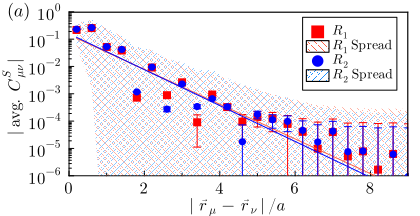

R2, m = -1.4628700501640193 ± 0.18808366384768166
R2 corr, ξ = -0.683587718463358 ± 0.08789002320161673
R3, m = -1.5125931957978893 ± 0.20017947495819127
R3 corr, ξ = -0.6611162887537004 ± 0.08749339342308339


In [ ]:
p = plot(xlim = (0,9), ylim=(1e-6,1),yaxis=:log)
trimlim = [0,6]
plt_corr(data2, data3, trimlim)

plot!(bottom_margin=1Plots.mm)
plot!(xlabel= "\$ | \\vec{r}_{\\mu} - \\vec{r}_{\\nu} \\; |/a \$")
plot!(ylabel= L"$|\textrm{avg.~} C_{\mu\nu}^S |$")
p = plot!(xticks=[0,2,4,6,8,10], xminorticks=2)

plot!( grid = false, widen=false, framestyle=:semi, legend=:topright)
vline!(p, [xlims(p)[2]], lc=:black, lw=2, label="")
hline!(p, [ylims(p)[2]], lc=:black, lw=2, label="")

# annotate!(-1.3,1, text(L"(a)", 12))
# plot!(legend=false)
plot!(p, yminorticks=10)
# savefig("./images/paper/dimer-std-referee.svg")
display(p)

### Log-log scale plot

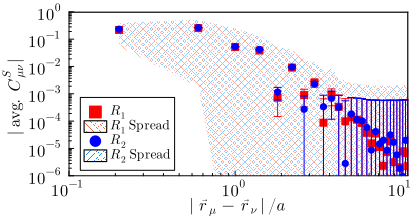

In [ ]:
p = plot(xlim = (0.1,11), ylim=(1e-6,1),yaxis=:log, xaxis=:log)
trimlim = [0,6]
plt_corr(data2, data3, trimlim,false)

plot!(bottom_margin=1Plots.mm)
plot!(xlabel= "\$ | \\vec{r}_{\\mu} - \\vec{r}_{\\nu} \\; |/a \$")
plot!(ylabel= L"$|\textrm{avg.~} C_{\mu\nu}^S |$")
p = plot!(xticks=[0.1,1.0,10], xminorticks=10)

plot!( grid = false, widen=false, framestyle=:semi, legend=:bottomleft)
vline!(p, [xlims(p)[2]], lc=:black, lw=2, label="")
hline!(p, [ylims(p)[2]], lc=:black, lw=2, label="")

plot!(p, yminorticks=10)
# savefig("./images/paper/dimer-std-log-log-2e4.svg")
display(p)

# Vison

In [37]:
# dist_mean, corr_mean, env_dn, env_up, err_mean, rgn, fraction, log_dev, bins = load("./data/plot_data/referee/correct-mc-bins-R2-vison-std-2e4.jld")["vison_plot_data"]
dist_mean, corr_mean, env_dn, env_up, err_mean, rgn, fraction, log_dev, bins = load("./data/plot_data/correct-mc-bins-R2-vison-std.jld")["vison_plot_data"]
data2 = dist_mean, corr_mean, std.(bins), err_mean

# dist_mean, corr_mean, env_dn, env_up, err_mean, rgn, fraction, log_dev, bins = load("./data/plot_data/referee/correct-mc-bins-R3-vison-std-2e4.jld")["vison_plot_data"]
dist_mean, corr_mean, env_dn, env_up, err_mean, rgn, fraction, log_dev, bins = load("./data/plot_data/correct-mc-bins-R3-vison-std.jld")["vison_plot_data"]
data3 = dist_mean, corr_mean, std.(bins), err_mean

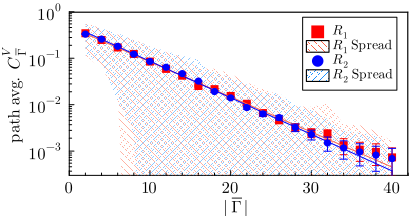

R2, m = -0.1741330091393677 ± 0.0023588203685429407
R2 corr, ξ = -5.742736572131755 ± 0.07779159198173172
R3, m = -0.18124643429019993 ± 0.0018194394611667382
R3 corr, ξ = -5.517349921482403 ± 0.05538582983727736


In [38]:
p = plot(xlim = (0,42), ylim=(3e-4,1.0),yaxis=:log)
trimlim = [0,35]
plt_corr(data2, data3, trimlim)

plot!(xminorticks =5)
plot!(yticks=[1e-4, 1e-3, 1e-2, 1e-1, 1e0], yminorticks=10)
plot!(xlabel= L"$|\overline{\Gamma}\;|$", ylabel=L"\textrm{path~avg.~}C_{\overline{\Gamma}}^V")
plot!( grid = false, widen=false, framestyle=:semi, legend=:topright)
vline!(p, [xlims(p)[2]], lc=:black, lw=2, label="")
hline!(p, [ylims(p)[2]], lc=:black, lw=2, label="")

# savefig("./images/paper/vison-std-2e4.svg")
display(p)

## Vison Euclidean

In [43]:
avg_d, avg_cs, avg_err, region, averaging_radius, bins = load("./data/plot_data/referee/correct-mc-bins-R2-vison-std-ed-2e4.jld")["euclidean_vison_plot_data"]
# avg_d, avg_cs, avg_err, region, averaging_radius, bins = load("./data/plot_data/correct-mc-bins-R2-vison-std-ed.jld")["euclidean_vison_plot_data"]
data2 = avg_d, avg_cs, std.(bins), avg_err

avg_d, avg_cs, avg_err, region, averaging_radius, bins = load("./data/plot_data/referee/correct-mc-bins-R3-vison-std-ed-2e4.jld")["euclidean_vison_plot_data"]
# avg_d, avg_cs, avg_err, region, averaging_radius, bins = load("./data/plot_data/correct-mc-bins-R3-vison-std-ed.jld")["euclidean_vison_plot_data"]
data3 = avg_d, avg_cs, std.(bins), avg_err

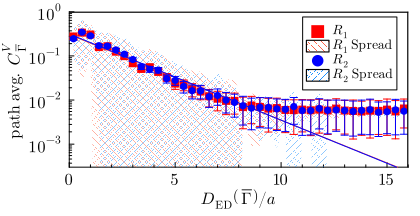

R2, m = -0.44640338174633154 ± 0.017207004890624152
R2 corr, ξ = -2.2401263988816495 ± 0.08634761177296923
R3, m = -0.4498230127278886 ± 0.0166452279110856
R3 corr, ξ = -2.2230965773308045 ± 0.08226335280985361


In [44]:
p = plot(xlim = (0,16), ylim=(3e-4,1.0),yaxis=:log)
trimlim = [0,10]
plt_corr(data2, data3, trimlim)
plot!(bottom_margin=3Plots.mm)

plot!(xminorticks =5)
plot!(yticks=[1e-4, 1e-3, 1e-2, 1e-1, 1e0], yminorticks=10)
plot!( grid = false, widen=false, framestyle=:semi, legend=:topright)
vline!(p, [xlims(p)[2]], lc=:black, lw=2, label="")
hline!(p, [ylims(p)[2]], lc=:black, lw=2, label="")

plot!(xlabel= L"$D_{\textrm{ED}}\left( \overline{\Gamma} \right)/a$", ylabel=L"\textrm{path~avg.~}C_{\overline{\Gamma}}^V")
savefig("./images/paper/vison-std-ed-2e4.svg")
display(p)

# Open and closed Wilson loops
Path averages of  the true numerator and the true denominator of the FM order parameters. The numerator DOES NOT have a sqrt of products and the denominator also DOES NOT have a sqrt.


In [ ]:
function plot_fm_setting(p)
    plot!(p, grid = false, legend = false, widen=false, framestyle=:semi)
    vline!(p, [xlims(p)[2]], lc=:black, lw=2)
    hline!(p, [ylims(p)[2]], lc=:black, lw=2)
    size_paper_fm = 1.2 .* (175,160)
    plot!(p, size = size_paper_fm)
    plot!(p, yminorticks=10)
end

In [ ]:
mkrsz = 3

## Monomer FM Numerator Product

In [ ]:
fl = load( "./data/plot_data/correct-mc-bins-mfm-num-prod-R2-new-no-sqrt.jld")
# fl = load( "./data/plot_data/correct-mc-bins-mfm-num-prod-R2-new-no-sqrt.jld")
mean_num_prod, mean_dist_num_prod, env_up, env_dn, mean_dev_num_prod, bins = fl["mean_num_prod"], fl["mean_dist_num_prod"], fl["env_up"], fl["env_dn"], fl["mean_dev_num_prod"], fl["bins"]
inds = 1:length(mean_dev_num_prod) # findall(x->x < 1, mean_dev_num_prod) 
data2 = mean_dist_num_prod[inds], mean_num_prod[inds], std.(bins)[inds], mean_dev_num_prod[inds]

fl = load( "./data/plot_data/correct-mc-bins-mfm-num-prod-R3-new-no-sqrt.jld")
mean_num_prod, mean_dist_num, env_up, env_dn, mean_dev_num_prod, bins = fl["mean_num_prod"], fl["mean_dist_num_prod"], fl["env_up"], fl["env_dn"], fl["mean_dev_num_prod"], fl["bins"]
inds = 1:length(mean_dev_num_prod) # findall(x->x < 1, mean_dev_num_prod) 
data3 = mean_dist_num_prod[inds], mean_num_prod[inds], std.(bins)[inds], mean_dev_num_prod[inds]


In [ ]:
pa = plot(xlim = (3,21), ylim=(1e-8,1e-2),yaxis=:log)
trimlim = [0,21]
plt_corr(data2, data3, trimlim;mkrsz=mkrsz)
plot!(yticks = [1e-8, 1e-6, 1e-4, 1e-2],xminorticks = 2, xticks=[4, 8, 12, 16, 20])
plot!(xlabel= L"$ |\Gamma_1\;| + |\Gamma_2\;|$")
# plot!(xlabel= L"$ |\Gamma\;|$")
# plot!(ylabel=L"N_m(|\Gamma\;|)")
plot!(ylabel=L"\mathbb{E} \left[ F_{\Gamma_{1}\Gamma_{2}}^{\textrm{op}} \right]")
# annotate!(0.2, 0.4, text(L"(a)", 12))
# plot!(top_margin=2Plots.mm)
annotate!(18.7,1.5e-3, text(L"(a)", 12))
plot_fm_setting(pa)
# savefig("./images/paper/mfm-num-prod-std-no-sqrt.svg")
display(pa)

## Monomer FM Denominator Product

In [ ]:
fl = load( "./data/plot_data/correct-mc-bins-mfm-den-R2-new-no-sqrt.jld")
mean_den, mean_dist_den, env_up, env_dn, mean_dev_den, bins = fl["mean_den"], fl["mean_dist_den"], fl["env_up"], fl["env_dn"], fl["mean_dev_den"], fl["bins"]
data2 = mean_dist_den, mean_den, std.(bins), mean_dev_den

fl = load( "./data/plot_data/correct-mc-bins-mfm-den-R3-new-no-sqrt.jld")
mean_den, mean_dist_den, env_up, env_dn, mean_dev_den, bins = fl["mean_den"], fl["mean_dist_den"], fl["env_up"], fl["env_dn"], fl["mean_dev_den"], fl["bins"]
data3 = mean_dist_den, mean_den, std.(bins), mean_dev_den


In [ ]:
pb = plot(xlim = (3, 21), ylim=(1e-6,0.6),yaxis=:log)
trimlim=[0,21]
plt_corr(data2, data3, trimlim;mkrsz=mkrsz)
plot!(yticks = [ 1e-6, 1e-4,1e-2],xminorticks = 2, xticks=[4, 8, 12, 16, 20])
plot!(xlabel= L"$ |\Gamma\;|$", ylabel=L"\mathbb{E} \left[ F_{\Gamma}^{\textrm{cl}} \right]")
annotate!(18.7,0.1, text(L"(b)", 12))
# plot!(top_margin=3Plots.mm)
plot_fm_setting(pb)
# savefig("./images/paper/mfm-den-std-no-sqrt.svg")
display(pb)

## Vison FM numerator product no square root

In [ ]:
fl = load( "./data/plot_data/correct-mc-bins-vfm-num-prod-R2-std-no-sqrt.jld")
mean_dist_num_prod, mean_num_prod, env_up, env_dn, mean_dev_num_prod1, log_dev, bins = fl["mean_dist_num_prod"], fl["mean_num_prod"], fl["env_up"], fl["env_dn"], fl["mean_dev_num_prod"], fl["log_dev"], fl["bins"]
mean_dev_num_prod = mean_dev_num_prod1[2:end]
data2 = mean_dist_num_prod, mean_num_prod, std.(bins), mean_dev_num_prod

fl = load( "./data/plot_data/bins-vfm-num-prod-R3-std-no-sqrt.jld")
# fl = load( "./data/plot_data/correct-mc-bins-vfm-num-prod-R3-std-no-sqrt.jld")
mean_dist_num_prod, mean_num_prod, env_up, env_dn, mean_dev_num_prod1, log_dev, bins = fl["mean_dist_num_prod"], fl["mean_num_prod"], fl["env_up"], fl["env_dn"], fl["mean_dev_num_prod"], fl["log_dev"], fl["bins"]
mean_dev_num_prod = mean_dev_num_prod1[2:end]
data3 = mean_dist_num_prod, mean_num_prod, std.(bins), mean_dev_num_prod


In [ ]:
pc = plot(xlim = (1,54), ylim=(4e-6,0.7),yaxis=:log)
trimlim = [0,40]
ξ2, ξ3 = plt_corr(data2, data3, trimlim;mkrsz=mkrsz)
plot!(yticks = [1e-5, 1e-3, 1e-1], xticks=[0, 20, 40], xminorticks=4)
plot!(xlabel= L"$ |\overline{\Gamma}_1\;| + |\overline{\Gamma}_2\;|$")
# plot!(xlabel= L"$ |\overline{\Gamma}\;|$")
# plot!(ylabel=L"N_{v} (|\overline{\Gamma}\;|) ")
# plot!(ylabel=L"\mathbb{E} \left[ | \langle \hat{V}( \overline{\Gamma}_{1} ) \rangle \langle \hat{V}( \overline{\Gamma}_{2} ) \rangle | \right] ")
plot!(ylabel=L"\mathbb{E} \left[ G_{\overline{\Gamma}_1 \overline{\Gamma}_2 }^{\textrm{op}} \right] ")
# plot!(bottom_margin=3Plots.mm)
plot_fm_setting(pc)
annotate!(48,0.15, text(L"(c)", 12))
# savefig("./images/paper/vfm-num-prod-std-no-sqrt.svg")
display(pc)

In [ ]:
start_pt = 15
corr_lens2 = [ plt_corr(data2, data3, [start_pt,i];verbose=false)[1] for i in [25, 30, 35, 40, 45], start_pt in [0, 5, 10]] ;
corr_lens3 = [ plt_corr(data2, data3, [start_pt,i];verbose=false)[2] for i in [25, 30, 35, 40, 45], start_pt in [0, 5, 10]];
println(mean(corr_lens2)," ± ", std(corr_lens2))
println(mean(corr_lens3)," ± ", std(corr_lens3))

## Vison FM denominator no square root

In [ ]:
# fl = load( "./data/plot_data/bins-vfm-den-R2-std-no-sqrt.jld")
fl = load( "./data/plot_data/correct-mc-bins-vfm-den-R2-std-no-sqrt.jld")
mean_dist_den, mean_den, env_up, env_dn, mean_dev_den1, log_dev, bins = fl["mean_dist_den"], fl["mean_den"], fl["env_up"], fl["env_dn"], fl["mean_dev_den"], fl["log_dev"], fl["bins"]
mean_dev_den = mean_dev_den1[2:end]
inds = findall(x->x < 1, mean_dev_den) 
data2 = mean_dist_den[inds], mean_den[inds], std.(bins)[inds], mean_dev_den[inds]

fl = load( "./data/plot_data/correct-mc-bins-vfm-den-R3-std-no-sqrt.jld")
# fl = load( "./data/plot_data/bins-vfm-den-R3-std-no-sqrt.jld")
mean_dist_den, mean_den, env_up, env_dn, mean_dev_den1, log_dev, bins = fl["mean_dist_den"], fl["mean_den"], fl["env_up"], fl["env_dn"], fl["mean_dev_den"], fl["log_dev"], fl["bins"]
mean_dev_den = mean_dev_den1[2:end]
inds = findall(x->x < 1, mean_dev_den) 
data3 = mean_dist_den[inds], mean_den[inds], std.(bins)[inds], mean_dev_den[inds]

In [ ]:
pd = plot(xlim = (3,54), ylim=(1e-4,1),yaxis=:log)
trimlim = [0,40]
plt_corr(data2, data3, trimlim; mkrsz=mkrsz)
plot!(yticks = [1e-4, 1e-3, 1e-2, 1e-1, 1e0], xticks=[0, 20, 40], xminorticks=4)
plot!(xlabel= L"$ |\overline{\Gamma}\;|$", ylabel=L"\mathbb{E} \left[ G_{\overline{\Gamma}}^{\textrm{cl}} \right]")
# plot!(bottom_margin=3Plots.mm)
plot_fm_setting(pd)
annotate!(48,0.3, text(L"(d)", 12))
# savefig("./images/paper/vfm-den-std-no-sqrt.svg")
display(pd)

In [ ]:
start_pt = 15
corr_lens2 = [ plt_corr(data2, data3, [start_pt,i];verbose=false)[1] for i in [25, 30, 35, 40, 45], start_pt in [0, 5, 10]] ;
corr_lens3 = [ plt_corr(data2, data3, [start_pt,i];verbose=false)[2] for i in [25, 30, 35, 40, 45], start_pt in [0, 5, 10]];
println(mean(corr_lens2)," ± ", std(corr_lens2))

println(mean(corr_lens3)," ± ", std(corr_lens3))

In [ ]:
# plot!( top_margin=-1Plots.mm)
# plot!( bottom_margin=-5Plots.mm)
pcombined = plot(pa, pb, pc, pd, layout=(2,2), size = 1.2 .* (350,310), margins = 0.1Plots.mm)
# theme(:dark)
# savefig("./images/paper/fm-std-no-sqrt.svg")
display(pcombined)

In [ ]:
# display(pd)